In [23]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

Using cuda


In [25]:
# cria pasta de logs com data de hoje
import os
from datetime import datetime

data_hoje = datetime.now().strftime('%d-%m')
os.makedirs(f'../logs/{data_hoje}', exist_ok=True)

In [26]:
import logging

inicio_execucao = pd.Timestamp.now()

logging.basicConfig(filename=f'../logs/{data_hoje}/lstm.log', level=logging.INFO, format='- %(message)s')
logging.info('-' * 50)
logging.info(f'{inicio_execucao} - Iniciando o processo de treinamento do modelo LSTM')

In [27]:
df_original = pd.read_csv('../dados_tratados/combinado/Piratininga/Piratininga_tratado_combinado.csv',
                          usecols=['PM2.5', 'Data e Hora', 'PM10', 'Monóxido de Carbono'], low_memory=False)

In [28]:
df_original['Data e Hora'] = pd.to_datetime(df_original['Data e Hora'], format='%Y-%m-%d %H:%M:%S')
df_original.index = df_original['Data e Hora']
df_original.sort_index(inplace=True)

# colunas_selecionadas = ['PM2.5', 'PM10', 'Monóxido de Carbono']
colunas_selecionadas = ['PM2.5']
df = df_original[colunas_selecionadas]

df = df.loc['2019-01-01':'2022-01-01']

logging.info(f'Colunas Selecionadas: {colunas_selecionadas}')
df.head(20)

,PM2.5
Data e Hora,
2019-01-01 00:30:00,37.0
2019-01-01 01:30:00,23.0
2019-01-01 02:30:00,18.0
2019-01-01 03:30:00,13.0
2019-01-01 04:30:00,7.0
2019-01-01 05:30:00,2.0
2019-01-01 06:30:00,NaN
2019-01-01 07:30:00,NaN
2019-01-01 08:30:00,NaN


In [29]:
# Imputacao dos dados faltantes com a media da coluna

# df.fillna(df.mean(), inplace=True)

# df.interpolate(method='linear', inplace=True)

# from sklearn.impute import KNNImputer
# 
# imputer = KNNImputer(n_neighbors=5)
# 
# df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
# df.head(20)


In [30]:
def impute_missing_values(df):
    # Interpolação linear para valores faltantes
    df_interpolated = df.interpolate(method='time')
    
    # Para valores no início ou fim da série que não podem ser interpolados
    df_filled = df_interpolated.fillna(method='ffill').fillna(method='bfill')
    
    return df_filled

def remove_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower_bound, upper_bound)
    return df

# converte as colunas para float
df = df.apply(pd.to_numeric, errors='coerce')
df = df.replace(0.0, np.nan)
df = impute_missing_values(df)
df = remove_outliers(df)

C:\Users\portes\AppData\Local\Temp\ipykernel_5344\161559562.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_interpolated.fillna(method='ffill').fillna(method='bfill')


In [31]:
# from sklearn.preprocessing import MinMaxScaler
# 
# scaler = MinMaxScaler(feature_range=(0, 1))
# 
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
# 
# df.head(20)

In [32]:
def split_data(df, train_ratio=0.7, val_ratio=0.15):
    # Ensure the data is sorted by date
    df = df.sort_index()
    
    # Calculate split points
    train_split = int(len(df) * train_ratio)
    val_split = int(len(df) * (train_ratio + val_ratio))
    
    # Split the data
    df_train = df.iloc[:train_split]
    df_val = df.iloc[train_split:val_split]
    df_test = df.iloc[val_split:]
    
    return df_train, df_val, df_test

# Split the data
df_train, df_val, df_test = split_data(df)

In [33]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df_train, df_val, df_test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), 
                                   columns=df_train.columns, 
                                   index=df_train.index)
    df_val_scaled = pd.DataFrame(scaler.transform(df_val), 
                                 columns=df_val.columns, 
                                 index=df_val.index)
    df_test_scaled = pd.DataFrame(scaler.transform(df_test), 
                                  columns=df_test.columns, 
                                  index=df_test.index)
    return df_train_scaled, df_val_scaled, df_test_scaled, scaler

# Divisão dos dados (ver próximo passo)
# df_train, df_val, df_test = split_data(df)

# Normalização
df_train_scaled, df_val_scaled, df_test_scaled, scaler = normalize_data(df_train, df_val, df_test)

In [34]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)


seq_length = 8
# X, y = create_sequences(df.values, seq_length)
X_train, y_train = create_sequences(df_train_scaled.values, seq_length)
X_val, y_val = create_sequences(df_val_scaled.values, seq_length)
X_test, y_test = create_sequences(df_test_scaled.values, seq_length)


In [35]:
# # X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# # X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# 
# # corretamente separando os dados de treino, validação e teste de acordo com a ordem temporal
# train_size = int(0.7 * len(X))
# val_size = int(0.15 * len(X))
# test_size = len(X) - train_size - val_size
# 
# X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
# X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
# 
# 
# logging.info(f'X_train shape: {X_train.shape}'
#              f', X_val shape: {X_val.shape}'
#              f', X_test shape: {X_test.shape}')
# 
# X_train.shape, X_val.shape, X_test.shape

In [36]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().reshape(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().reshape(-1, 1)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [37]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

input_size = X_train.shape[2]


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, drop_prob,
                 activation_function):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.activation_function = activation_function

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        if self.activation_function == 'relu':
            predictions = nn.ReLU()(predictions)
        elif self.activation_function == 'sigmoid':
            predictions = nn.Sigmoid()(predictions)
        elif self.activation_function == 'tanh':
            predictions = nn.Tanh()(predictions)
        elif self.activation_function == 'leaky_relu':
            predictions = nn.LeakyReLU()(predictions)
        return predictions


def train_and_evaluate_lstm(input_size, hidden_layer_size, num_layers, lr, batch_size, drop_prob, activation_function,
                            weight_decay, num_epochs, patience):
    model = LSTM(
        input_size=input_size,
        hidden_layer_size=hidden_layer_size,
        num_layers=num_layers,
        drop_prob=drop_prob,
        output_size=1,
        activation_function=activation_function
    ).to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    # Early stopping 
    best_val_loss = np.inf
    epochs_no_improve = 0
    val_losses = []

    def train_model():
        model.train()
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

    def evaluate_model():
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                val_loss += single_loss.item() * seq.size(0)
        val_loss /= len(val_loader.dataset)
        return val_loss

    for epoch in range(num_epochs):
        train_model()
        val_loss = evaluate_model()
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping after {} epochs".format(epoch + 1))
                break

    return model, val_losses


from sklearn.base import BaseEstimator, RegressorMixin


class PyTorchLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layer_size=2, num_layers=2, lr=0.001, batch_size=64, drop_prob=1.0,
                 activation_function='relu', weight_decay=1e-8, num_epochs=5, patience=30):
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lr = lr
        self.drop_prob = drop_prob
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.patience = patience

    def fit(self, X, y):
        self.model, self.val_losses = train_and_evaluate_lstm(
            input_size=input_size,
            hidden_layer_size=self.hidden_layer_size,
            num_layers=self.num_layers,
            lr=self.lr,
            batch_size=self.batch_size,
            drop_prob=self.drop_prob,
            activation_function=self.activation_function,
            weight_decay=self.weight_decay,
            num_epochs=self.num_epochs,
            patience=self.patience
        )
        return self

    def predict(self, X):
        self.model.eval()
        test_data = torch.from_numpy(X).float()
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        predictions = []
        with torch.no_grad():
            for seq in test_loader:
                seq = seq.to(device)
                y_pred = self.model(seq)
                predictions.append(y_pred.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)
        return predictions

In [38]:
# Parâmetros para busca
param_space = {
    'hidden_layer_size': Integer(8, 256),
    'lr': Real(0.0001, 0.1, prior='log-uniform'),
    'num_layers': Integer(1, 10),
    'batch_size': Categorical([32, 64, 128]),
    'num_epochs': Categorical([400]),
    'activation_function': Categorical(['relu', 'sigmoid', 'tanh', 'leaky_relu']),
    'drop_prob': Real(0.0, 0.5),
    'weight_decay': Real(1e-8, 1e-3, prior='log-uniform'),
}

logging.info(f'Espaco de Busca: \n{param_space}')

In [39]:
tscv = TimeSeriesSplit(n_splits=3)

# Usando BayesSearchCV
bayes_search = BayesSearchCV(estimator=PyTorchLSTMRegressor(), search_spaces=param_space,
                             scoring='neg_mean_squared_error', cv=tscv, n_iter=1, random_state=42, verbose=3)
bayes_search.fit(X_train.numpy(), y_train.numpy())

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Early stopping after 120 epochs
[CV 1/3] END activation_function=sigmoid, batch_size=128, drop_prob=0.46643399942391695, hidden_layer_size=86, lr=0.010243393225105073, num_epochs=400, num_layers=4, weight_decay=4.983347481602242e-05;, score=-0.020 total time= 1.4min
Early stopping after 63 epochs
[CV 2/3] END activation_function=sigmoid, batch_size=128, drop_prob=0.46643399942391695, hidden_layer_size=86, lr=0.010243393225105073, num_epochs=400, num_layers=4, weight_decay=4.983347481602242e-05;, score=-0.030 total time=  45.7s
Early stopping after 34 epochs
[CV 3/3] END activation_function=sigmoid, batch_size=128, drop_prob=0.46643399942391695, hidden_layer_size=86, lr=0.010243393225105073, num_epochs=400, num_layers=4, weight_decay=4.983347481602242e-05;, score=-0.022 total time=  24.5s
Early stopping after 67 epochs


BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
              estimator=PyTorchLSTMRegressor(), n_iter=1, random_state=42,
              scoring='neg_mean_squared_error',
              search_spaces={'activation_function': Categorical(categories=('relu', 'sigmoid', 'tanh', 'leaky_relu'), prior=None),
                             'batch_size': Categorical(categories=(32, 64, 128), prior=None),
                             'd...
                             'hidden_layer_size': Integer(low=8, high=256, prior='uniform', transform='normalize'),
                             'lr': Real(low=0.0001, high=0.1, prior='log-uniform', transform='normalize'),
                             'num_epochs': Categorical(categories=(400,), prior=None),
                             'num_layers': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'weight_decay': Real(low=1e-08, high=0.001, prior='log-uniform', transform='normalize')},
              verbose=3)

In [40]:
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_

X_val_np = X_val.numpy()
y_val_np = y_val.numpy()

y_pred = bayes_search.best_estimator_.predict(X_val_np)

epsilon = 1e-10
MAPE = np.mean(np.abs((y_val_np - y_pred) / (y_val_np + epsilon))) * 100
RMSE = np.sqrt(np.mean((y_val_np - y_pred) ** 2))
MSE = np.mean((y_val_np - y_pred) ** 2)
MAE = np.mean(np.abs(y_val_np - y_pred))
R2 = np.corrcoef(y_val_np.flatten(), y_pred.flatten())[0, 1] ** 2

print(f'Melhores Parâmetros: \n{best_params}'
      f'\nMelhor Score: {best_score}'
      # f'\nMAPE: {MAPE}'
      f'\nMSE: {MSE}'
      f'\nRMSE: {RMSE}'
      f'\nMAE: {MAE}'
      f'\nR2: {R2}'
      )

logging.info(f'Melhores Parâmetros: {best_params}')
logging.info(f'Melhor Score: {best_score}')
# logging.info(f'MAPE: {MAPE}')
logging.info(f'RMSE: {RMSE}')
logging.info(f'MAE: {MAE}')
logging.info(f'R2: {R2}')

Melhores Parâmetros: 
OrderedDict([('activation_function', 'sigmoid'), ('batch_size', 128), ('drop_prob', 0.46643399942391695), ('hidden_layer_size', 86), ('lr', 0.010243393225105073), ('num_epochs', 400), ('num_layers', 4), ('weight_decay', 4.983347481602242e-05)])
Melhor Score: 0.02446210818986098
MSE: 0.02749413438141346
RMSE: 0.16581355035305023
MAE: 0.12001325935125351
R2: 0.5642595005689082


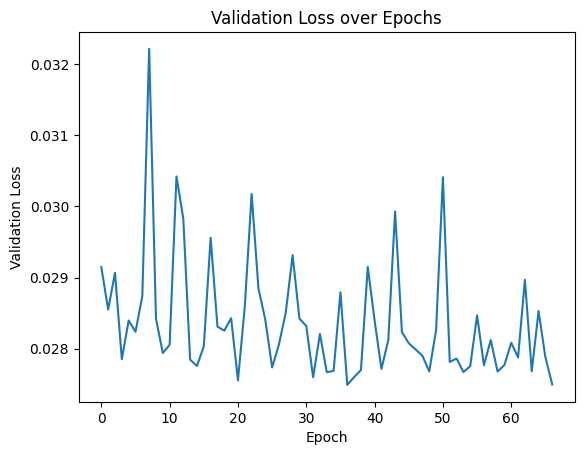

In [41]:
plt.plot(bayes_search.best_estimator_.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.show()

In [42]:
# Treinar o modelo com os melhores parâmetros encontrados
best_params = bayes_search.best_params_
print("Training with best parameters...")
print(best_params)

Training with best parameters...
OrderedDict([('activation_function', 'sigmoid'), ('batch_size', 128), ('drop_prob', 0.46643399942391695), ('hidden_layer_size', 86), ('lr', 0.010243393225105073), ('num_epochs', 400), ('num_layers', 4), ('weight_decay', 4.983347481602242e-05)])


In [43]:
model, val_losses = train_and_evaluate_lstm(input_size=input_size, **best_params, patience=50)

# Fazer predições
model.eval()
with torch.no_grad():
    y_pred = model(X_val.to(device)).cpu().numpy()

Early stopping after 177 epochs


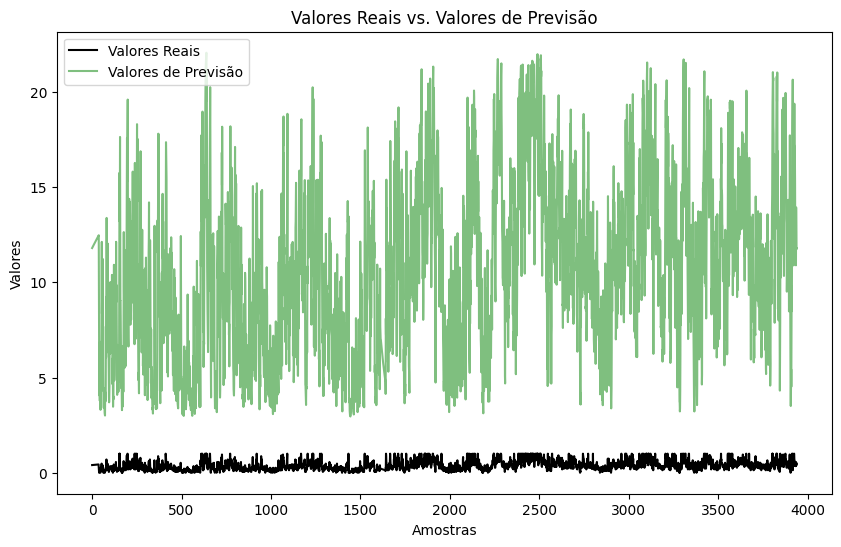

In [44]:
y_pred_original_scale = scaler.inverse_transform(y_pred)

plt.figure(figsize=(10, 6))
plt.plot(y_val.numpy(), label='Valores Reais', color='black', alpha=1)
plt.plot(y_pred_original_scale, label='Valores de Previsão', color='green', alpha=0.5)
plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.title('Valores Reais vs. Valores de Previsão')
plt.legend()
plt.show()

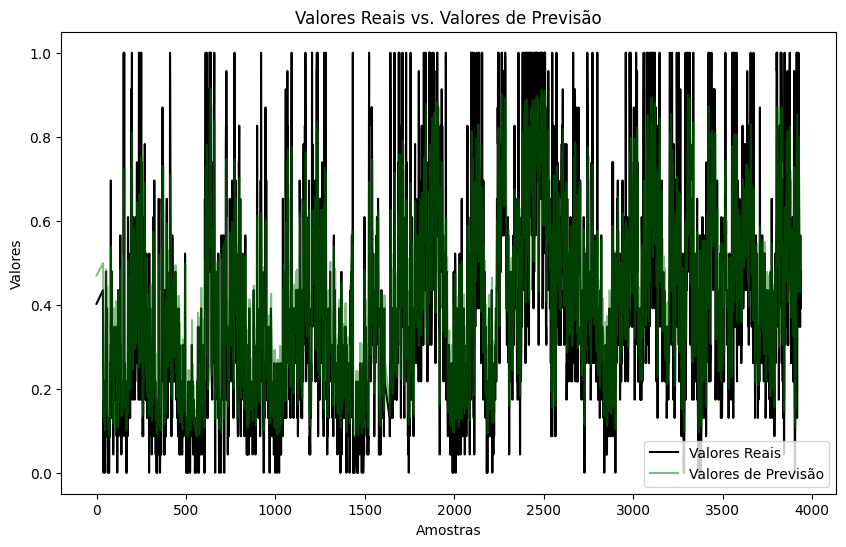

OSError: [Errno 22] Invalid argument: '../logs/.imagens/27-07/lstm_valores_reais_vs_previsao2024-07-27 23:58:49.039486.png'

<Figure size 640x480 with 0 Axes>

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(y_val.numpy(), label='Valores Reais', color='black', alpha=1)
plt.plot(y_pred, label='Valores de Previsão', color='green', alpha=0.5)

plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.title('Valores Reais vs. Valores de Previsão')
plt.legend()
plt.show()

# Salvar a imagem
os.makedirs(f'../logs/.imagens/{data_hoje}', exist_ok=True)
image_path = f'../logs/.imagens/{data_hoje}/lstm_valores_reais_vs_previsao' + str(inicio_execucao) + '.png'
plt.savefig(image_path)

In [ ]:
logging.info(f'Imagem Salva: {image_path}')

In [ ]:
logging.info(f'{pd.Timestamp.now()} - Fim do processo de treinamento do modelo LSTM')